# FTDI Device Info

In [19]:
from pyftdi.ftdi import Ftdi

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            # entry can be (UsbDeviceDescriptor, interface) or similar
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            # UsbDeviceDescriptor fields
            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04x}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04x}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : {serial or 'Unknown'}")
            print(f"   Description : {description or 'Unknown'}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : ￿￿￿￿￿￿￿￿
   Description : ￿￿￿￿￿￿
   Interfaces  : 1



In [20]:
from pyftdi.ftdi import Ftdi

def safe_to_hex_string(value):
    """Return UTF-8 string if printable, else show hex representation."""
    if value is None:
        return 'None'
    try:
        if all(0x20 <= ord(c) <= 0x7E for c in value):
            return value  # printable ASCII
        else:
            raise UnicodeEncodeError
    except Exception:
        return ' '.join(f'{ord(c):02X}' for c in value)

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04X}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04X}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : 0x{safe_to_hex_string(serial)}")
            print(f"   Description : 0x{safe_to_hex_string(description)}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : 0xFFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFF
   Description : 0xFFFF FFFF FFFF FFFF FFFF FFFF
   Interfaces  : 1



# FTDI FT232H Sanity Test

In [1]:
from pyftdi.ftdi import Ftdi
from pyftdi.i2c import I2cController
from IPython.display import display, Markdown
import traceback

'''
Bus Rate
-  100 kHz ... default
-  400 kHz
- 1000 kHz
'''

BUS_RATE = 4e5


display(Markdown("## 🔍 FT232H Sanity Test"))

try:
    display(Markdown("**🔹 Scanning for FTDI devices...**"))
    Ftdi.show_devices()
except Exception as e:
    display(Markdown(f"❌ **Could not list FTDI devices:** `{e}`"))
    traceback.print_exc()
else:
    try:
        display(Markdown("**🔹 Initializing I2C interface...**"))
        i2c = I2cController()
        i2c.configure('ftdi://ftdi:232h/1', frequency=BUS_RATE) 


        freq = i2c.frequency
        display(Markdown(f"✅ **Connected to FT232H via I2C** at **{freq/1000:.1f} kHz**"))

        # ✅ Manually scan I2C addresses 0x03–0x77
        display(Markdown("**🔹 Scanning I2C bus...**"))
        found = []
        for addr in range(0x03, 0x78):
            try:
                port = i2c.get_port(addr)
                port.read(1)  # Try reading one byte (safe test)
                found.append(addr)
            except Exception:
                # No device responded
                pass

        if found:
            md = "\n".join([f"- `0x{addr:02X}`" for addr in found])
            display(Markdown(f"✅ **Found I2C devices:**\n{md}"))
        else:
            display(Markdown("⚠️ **No I2C devices detected.** Check wiring or power."))

        i2c.terminate()
        display(Markdown("✅ **Test complete — FT232H is working properly.**"))

    except Exception as e:
        display(Markdown(f"❌ **Failed to communicate with FT232H:** `{e}`"))
        traceback.print_exc()


## 🔍 FT232H Sanity Test

**🔹 Scanning for FTDI devices...**

Available interfaces:
  ftdi://ftdi:232h:1/1  (￿￿￿￿￿￿)



**🔹 Initializing I2C interface...**

✅ **Connected to FT232H via I2C** at **400.0 kHz**

**🔹 Scanning I2C bus...**

✅ **Found I2C devices:**
- `0x68`

✅ **Test complete — FT232H is working properly.**

# Capture Class

In [2]:
import numpy as np
from typing import Any, Callable, Optional, Dict
from pyftdi.i2c import I2cController
import struct, time, sys
from typing import List, Dict, Optional

CalibrationCallback = Callable[[Dict[str, Any], Any], Dict[str, Any]]

class MPU6050:
    # --- I2C address ---
    DEFAULT_ADDR = 0x68

    # --- Registers ---
    REG_SMPLRT_DIV   = 0x19
    REG_CONFIG       = 0x1A
    REG_GYRO_CONFIG  = 0x1B
    REG_ACCEL_CONFIG = 0x1C
    REG_FIFO_EN      = 0x23
    REG_INT_ENABLE   = 0x38
    REG_INT_STATUS   = 0x3A
    REG_TEMP_OUT_H   = 0x41
    REG_TEMP_OUT_L   = 0x42
    REG_USER_CTRL    = 0x6A
    REG_PWR_MGMT_1   = 0x6B
    REG_PWR_MGMT_2   = 0x6C
    REG_FIFO_COUNTH  = 0x72
    REG_FIFO_COUNTL  = 0x73
    REG_FIFO_R_W     = 0x74
    REG_WHO_AM_I     = 0x75

    # --- Scales (±2 g, ±250 °/s) ---
    ACCEL_SCALE = 16384.0
    GYRO_SCALE  = 131.0

    def __init__(
        self,
        url: str = "ftdi://ftdi:232h/1",
        bus_rate: int = 400_000,
        addr: int = DEFAULT_ADDR,
        sample_div: int = 4,      # 1kHz/(1+div) => 200 Hz
        dlpf_cfg: int = 0x03,     # 42 Hz
        accel_cfg: int = 0x00,    # ±2 g
        gyro_cfg: int = 0x00,     # ±250 dps
        verbose: bool = True,
        check_id: bool = True,
        callback: Optional[CalibrationCallback] = None, 
        user_data: Any = None 
    ):
        self.verbose = verbose
        self.addr = addr

        # --- I2C setup ---
        self.i2c = I2cController()
        self.i2c.configure(f"{url}?frequency={bus_rate}")
        self.mpu = self.i2c.get_port(self.addr)

        if self.verbose:
            print(f"🧩 Connected via {url} @ {bus_rate} Hz, addr=0x{self.addr:02X}")

        # Optional identity check
        if check_id:
            who = self._read8(self.REG_WHO_AM_I)
            print(f"🆔 WHO_AM_I = 0x{who:02X}")
            if who != 0x68 and self.verbose:
                print("⚠️ Unexpected WHO_AM_I (check AD0/wiring)")

        self.callback = callback
        self.user_data = user_data
                
        # Init
        self._soft_init(sample_div, dlpf_cfg, accel_cfg, gyro_cfg)
        if self.verbose:
            self.dump_regs()

    # --------- Low-level I²C helpers ---------
    def _write8(self, reg: int, val: int) -> None:
        self.mpu.write_to(reg, bytes([val & 0xFF]))
        time.sleep(0.002)

    def _read8(self, reg: int) -> int:
        return self.mpu.exchange([reg], 1)[0]

    def _read16_be(self, reg: int) -> int:
        return struct.unpack('>H', self.mpu.exchange([reg], 2))[0]

    def _fifo_read(self, nbytes: int) -> bytes:
        return self.mpu.exchange([self.REG_FIFO_R_W], nbytes)

    def _fifo_reset(self) -> None:
        self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) | 0x04)
        time.sleep(0.01)
        self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) & ~0x04)
        time.sleep(0.01)

    # --------- Temperature ---------
    def read_temperature(self) -> float:
        """Read temperature once (°C) using datasheet formula."""
        h = self._read8(self.REG_TEMP_OUT_H)
        l = self._read8(self.REG_TEMP_OUT_L)
        raw = (h << 8) | l
        if raw >= 0x8000:
            raw -= 0x10000
        return raw / 340.0 + 36.53

    # --------- Init / control ---------
    def _soft_init(self, sample_div: int, dlpf_cfg: int, accel_cfg: int, gyro_cfg: int) -> None:
        # No hard reset (clones may NACK after 0x80)
        self._write8(self.REG_PWR_MGMT_1, 0x01)  # PLL X-gyro
        self._write8(self.REG_PWR_MGMT_2, 0x00)  # all sensors on
        time.sleep(0.05)

        # Basic config
        self._write8(self.REG_CONFIG, dlpf_cfg & 0x07)
        self._write8(self.REG_SMPLRT_DIV, sample_div & 0xFF)
        self._write8(self.REG_GYRO_CONFIG, gyro_cfg & 0x18)   # FS bits [4:3]
        self._write8(self.REG_ACCEL_CONFIG, accel_cfg & 0x18) # FS bits [4:3]

        # FIFO off, reset
        self._write8(self.REG_USER_CTRL, 0x00)
        self._write8(self.REG_FIFO_EN, 0x00)
        self._fifo_reset()
        time.sleep(0.05)

        # Enable FIFO logic + select accel+gyro
        self._write8(self.REG_USER_CTRL, 0x40)   # FIFO_EN (logic)
        self._write8(self.REG_FIFO_EN, 0x78)     # XG|YG|ZG|ACCEL
        self._write8(self.REG_INT_ENABLE, 0x01)  # data-ready (optional)
        _ = self._read8(self.REG_INT_STATUS)     # clear stale interrupt

        # Quick FIFO growth sanity
        if self.verbose:
            for t in (0.05, 0.10, 0.20):
                time.sleep(t)
                cnt = self._read16_be(self.REG_FIFO_COUNTH)
                print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    def dump_regs(self) -> None:
        regs = [
            ("WHO_AM_I",     self.REG_WHO_AM_I),
            ("PWR_MGMT_1",   self.REG_PWR_MGMT_1),
            ("PWR_MGMT_2",   self.REG_PWR_MGMT_2),
            ("CONFIG",       self.REG_CONFIG),
            ("SMPLRT_DIV",   self.REG_SMPLRT_DIV),
            ("GYRO_CONFIG",  self.REG_GYRO_CONFIG),
            ("ACCEL_CONFIG", self.REG_ACCEL_CONFIG),
            ("USER_CTRL",    self.REG_USER_CTRL),
            ("FIFO_EN",      self.REG_FIFO_EN),
            ("INT_ENABLE",   self.REG_INT_ENABLE),
            ("INT_STATUS",   self.REG_INT_STATUS),
        ]
        print("\n🔎 Register dump:")
        for name, r in regs:
            print(f"   {name:<14}= 0x{self._read8(r):02X}")
        print()

    def calibrate(self, raw: Dict[str, any]) -> Dict[str, any]:
        if self.callback is None:
            return raw
            
        if not isinstance(raw, dict):
            raise TypeError(f"raw must be a dict, got {type(raw)}")
            
        return self.callback(raw, self.user_data)    

    # --------- Capture API ---------
    def capture(
        self,
        duration_s: Optional[float] = 5.0,
        max_samples: Optional[int] = None,
        print_rate_hz: float = 10.0,
        return_raw: bool = False,
        include_temp: bool = True,
    ) -> List[Dict[str, float]]:
        """
        Capture accel/gyro samples via FIFO, with optional temperature per batch.

        duration_s: stop after this many seconds (None to ignore)
        max_samples: stop after this many samples (None to ignore)
        print_rate_hz: terminal update rate (0 disables prints)
        return_raw: return raw ints instead of scaled floats
        include_temp: read temperature once per FIFO drain and add to each record

        Returns list of dicts: {t, ax, ay, az, gx, gy, gz, temp?}
        """
        if duration_s is None and max_samples is None:
            duration_s = 5.0

        data_log: List[Dict[str, float]] = []
        if self.verbose:
            print("📡 Capturing FIFO data... (Ctrl+C to stop)\n")

        t0 = time.time()
        last_print = 0.0
        bytes_per_sample = 12  # 6 accel + 6 gyro

        try:
            while True:
                if duration_s is not None and (time.time() - t0) >= duration_s:
                    break
                if max_samples is not None and len(data_log) >= max_samples:
                    break

                fifo_count = self._read16_be(self.REG_FIFO_COUNTH)

                if fifo_count > 1020:
                    self._fifo_reset()
                    continue

                if fifo_count < bytes_per_sample:
                    time.sleep(0.003)
                    continue

                # Read temperature once per batch if requested
                temp_c = self.read_temperature() if include_temp else None

                to_read = (fifo_count // bytes_per_sample) * bytes_per_sample
                blob = self._fifo_read(to_read)

                for i in range(0, len(blob), bytes_per_sample):
                    ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+bytes_per_sample])

                    rec_t = time.time()
                    if return_raw:
                        rec = {'t': rec_t, 'a': [ax, ay, az], 'g': [gx, gy, gz]}
                    else:
                        rec = {
                            't': rec_t,
                            'a': [ax/self.ACCEL_SCALE, ay/self.ACCEL_SCALE, az/self.ACCEL_SCALE],
                            'w': [gx/self.GYRO_SCALE, gy/self.GYRO_SCALE, gz/self.GYRO_SCALE]
                        }
                        # Calibration
                        rec = self.calibrate(rec)
                                        
                    if include_temp:
                        rec['temp'] = temp_c
                    data_log.append(rec)

                # Throttled console status
                if print_rate_hz and print_rate_hz > 0:
                    now = time.time()
                    if (now - last_print) >= (1.0 / print_rate_hz):
                        last_print = now
                        rec = data_log[-1]
                        if return_raw:
                            sys.stdout.write(
                                f"\rA=({rec['a'][0]:+6d},{rec['a'][1]:+6d},{rec['a'][2]:+6d})  "
                                f"G=({rec['w'][0]:+6d},{rec['w'][1]:+6d},{rec['w'][2]:+6d})  "
                                + (f"T={rec['temp']:.2f}°C  " if include_temp else "")
                                + f"n_samples={len(data_log)}     "
                            )
                        else:
                            sys.stdout.write(
                                f"\rA=({rec['a'][0]:+.3f},{rec['a'][1]:+.3f},{rec['a'][2]:+.3f}) g  "
                                f"G=({rec['w'][0]:+.2f},{rec['w'][1]:+.2f},{rec['w'][2]:+.2f}) °/s  "
                                + (f"T={rec['temp']:.2f}°C  " if include_temp else "")
                                + f"n_samples={len(data_log)}     "
                            )
                        sys.stdout.flush()

        except Exception as e:
            import traceback
            traceback.print_exc()
            raise
        except KeyboardInterrupt:
            print("\n🛑 Stopped by user.")
        finally:
            if self.verbose:
                print(f"\n📦 Recorded {len(data_log)} samples.")
            return data_log

    # --------- Cleanup / context manager ---------
    def close(self) -> None:
        try:
            self._write8(self.REG_FIFO_EN, 0x00)
            self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) & ~0x40)
        except Exception:
            pass
        self.i2c.terminate()
        if self.verbose:
            print("🔚 FIFO disabled, I²C connection closed.")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc, tb):
        self.close()

In [3]:
# --------- Example usage ---------
# if __name__ == "__main__":
#     try:
#         with MPU6050(
#             url="ftdi://ftdi:232h/1",
#             bus_rate=400_000,
#             sample_div=4,     # 200 Hz
#             dlpf_cfg=3,       # 42 Hz
#             accel_cfg=0x00,   # ±2 g
#             gyro_cfg=0x00,    # ±250 dps
#             verbose=True
#         ) as imu:
#             # e.g., capture for 3 seconds, show live prints, include temperature
#             samples = imu.capture(duration_s=3.0, max_samples=None, print_rate_hz=20.0, include_temp=True)

#             # samples is a list of dicts:
#             # [{'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ..., 'temp': ...}, ...]
#     except Exception as e:
#         print(f"❌ Error: {e}")

# Capture Accelerometer Calibration Data

In [4]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [5]:
samples = imu.capture(duration_s=300.0, max_samples=1e6, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.036,-0.004,+0.795) g  G=(-1.38,+0.60,+1.35) °/s  T=22.99°C  n_samples=7504         
🛑 Stopped by user.

📦 Recorded 7504 samples.


In [6]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


In [7]:
import pickle

calib_data = {"samples": samples}

with open("calib_samples_01.pkl", "wb") as f:
    pickle.dump(calib_data, f)

In [185]:
with open("calib_samples_01.pkl", "rb") as f:
    calib_data = pickle.load(f)

In [8]:
samples[0]

{'t': 1763145555.0679836,
 'a': [0.030029296875, 0.000732421875, 0.7974853515625],
 'w': [-1.381679389312977, 0.648854961832061, 1.3129770992366412],
 'temp': 23.053529411764707}

# Plot Data

📊 Recorded 7504 samples over 37.440 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.4 Hz → Δt = 4.99 ms


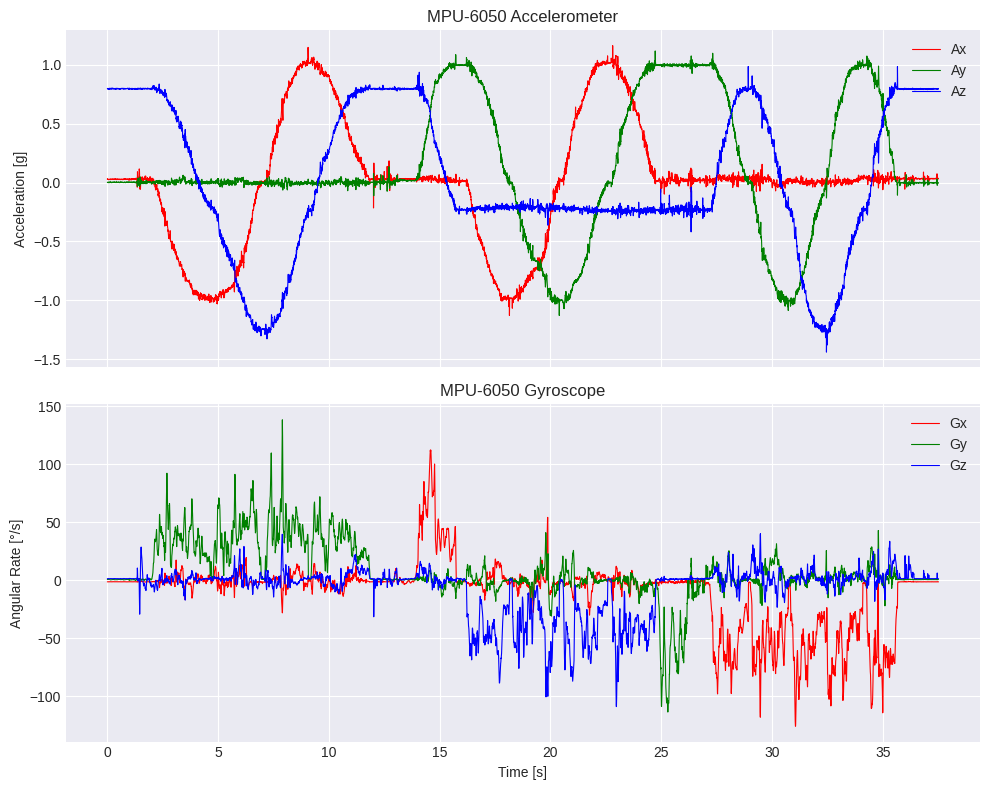

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpu6050_dictlog(data_log, sample_rate_hz=200):
    """
    Plot MPU-6050 data when each sample is a dict:
    {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}
    
    Arguments
    ----------
    data_log : list of dicts
        Recorded data points.
    sample_rate_hz : float
        Expected sample rate from the sensor configuration (Hz).
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to plot.")
        return

    n = len(data_log)

    # Extract recorded timestamps (real host-side times)
    host_t = np.array([d["t"] for d in data_log])
    total_time = host_t[-1] - host_t[0]
    actual_rate = (n - 1) / total_time if total_time > 0 else 0.0
    expected_rate = sample_rate_hz

    print(f"📊 Recorded {n} samples over {total_time:.3f} s")
    print(f"⚙️ Expected sample rate: {expected_rate:.1f} Hz → Δt = {1/expected_rate*1000:.2f} ms")
    print(f"🧠 Inferred actual rate: {actual_rate:.1f} Hz → Δt = {1/actual_rate*1000:.2f} ms")

    # Warn if difference >10%
    if abs(actual_rate - expected_rate) / expected_rate > 0.1:
        print("⚠️ WARNING: inferred rate differs from expected by >10% (host read delay or mis-set SMPLRT_DIV)")

    # Use synthetic uniform time base (true sample spacing)
    dt = 1.0 / expected_rate
    t = np.arange(n) * dt

    # Extract arrays
    ax = np.array([d["a"][0] for d in data_log])
    ay = np.array([d["a"][1] for d in data_log])
    az = np.array([d["a"][2] for d in data_log])
    gx = np.array([d["w"][0] for d in data_log])
    gy = np.array([d["w"][1] for d in data_log])
    gz = np.array([d["w"][2] for d in data_log])
   
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Accelerometer ---
    axs[0].plot(t, ax, "r-", lw=0.8, label="Ax")
    axs[0].plot(t, ay, "g-", lw=0.8, label="Ay")
    axs[0].plot(t, az, "b-", lw=0.8, label="Az")
    axs[0].set_ylabel("Acceleration [g]")
    axs[0].set_title("MPU-6050 Accelerometer")
    axs[0].legend(loc="upper right")

    # --- Gyroscope ---
    axs[1].plot(t, gx, "r-", lw=0.8, label="Gx")
    axs[1].plot(t, gy, "g-", lw=0.8, label="Gy")
    axs[1].plot(t, gz, "b-", lw=0.8, label="Gz")
    axs[1].set_ylabel("Angular Rate [°/s]")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_title("MPU-6050 Gyroscope")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_mpu6050_dictlog(samples)

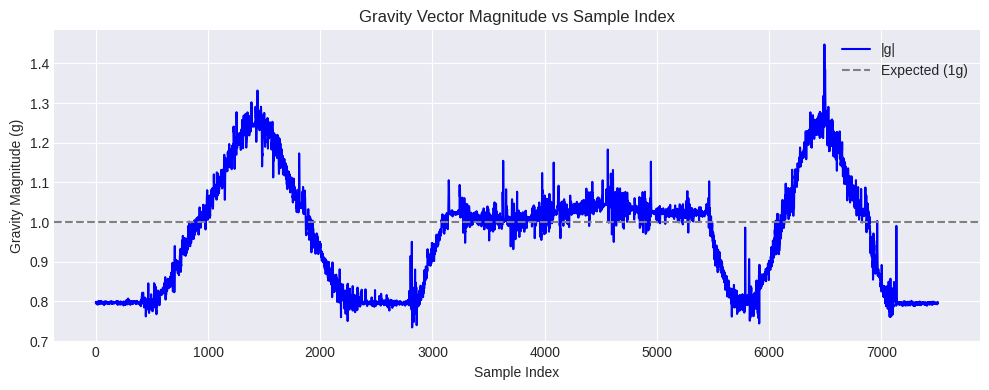

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gravity_magnitude(data_log):
    """
    Plots the magnitude of the gravity vector ||g|| = sqrt(ax^2 + ay^2 + az^2)
    using sample index on the x-axis.
    """
    # Extract acceleration values
    ax_vals = np.array([d['a'][0] for d in data_log])
    ay_vals = np.array([d['a'][1] for d in data_log])
    az_vals = np.array([d['a'][2] for d in data_log])

    # Compute magnitude of the gravity vector
    g_mag = np.sqrt(ax_vals**2 + ay_vals**2 + az_vals**2)

    # X-axis: sample index
    indices = np.arange(len(g_mag))

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(indices, g_mag, label='|g|', color='blue')
    plt.axhline(1.0, color='gray', linestyle='--', label='Expected (1g)')
    plt.xlabel("Sample Index")
    plt.ylabel("Gravity Magnitude (g)")
    plt.title("Gravity Vector Magnitude vs Sample Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_gravity_magnitude(samples)

# Plot 3D Data and Projections

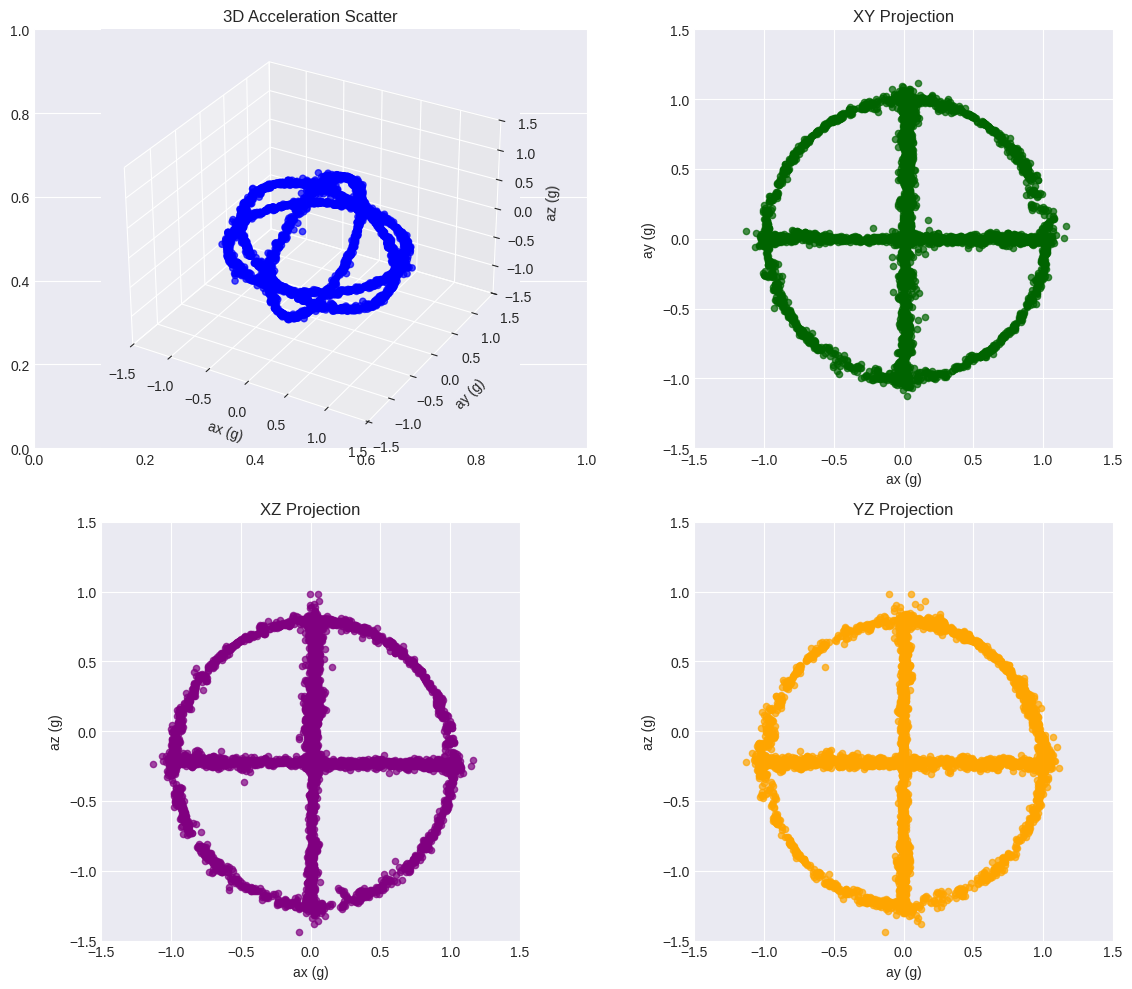

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_accel_3d_with_projections(data_log):
    """
    Plots 3D acceleration values (ax, ay, az) as dots,
    along with 2D projections on the XY, XZ, and YZ planes.
    All subplots are the same size and aspect ratio is fixed to 1:1.
    """

    val = 1.5
    axis_lim = [-val, val]

    # Extract acceleration data
    ax_vals = [d['a'][0] for d in data_log]
    ay_vals = [d['a'][1] for d in data_log]
    az_vals = [d['a'][2] for d in data_log]

    # Create figure with 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()  # Flatten to 1D list for indexed access

    # --- 3D Scatter plot (axs[0]) ---
    ax3d = fig.add_subplot(2, 2, 1, projection='3d')
    ax3d.scatter(ax_vals, ay_vals, az_vals, c='blue', s=20, alpha=0.7)
    ax3d.set_title('3D Acceleration Scatter')
    ax3d.set_xlabel('ax (g)')
    ax3d.set_ylabel('ay (g)')
    ax3d.set_zlabel('az (g)')

    # Set fixed 3D axis limits (optional: symmetrical around 0 or auto-computed)
    ax3d.set_xlim(axis_lim)
    ax3d.set_ylim(axis_lim)
    ax3d.set_zlim(axis_lim)

    # --- 2D Projection: XY (axs[1]) ---
    axs[1].scatter(ax_vals, ay_vals, c='darkgreen', s=20, alpha=0.7)
    axs[1].set_title('XY Projection')
    axs[1].set_xlabel('ax (g)')
    axs[1].set_ylabel('ay (g)')
    axs[1].grid(True)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_xlim(axis_lim)
    axs[1].set_ylim(axis_lim)

    # --- 2D Projection: XZ (axs[2]) ---
    axs[2].scatter(ax_vals, az_vals, c='purple', s=20, alpha=0.7)
    axs[2].set_title('XZ Projection')
    axs[2].set_xlabel('ax (g)')
    axs[2].set_ylabel('az (g)')
    axs[2].grid(True)
    axs[2].set_aspect('equal', adjustable='box')
    axs[2].set_xlim(axis_lim)
    axs[2].set_ylim(axis_lim)

    # --- 2D Projection: YZ (axs[3]) ---
    axs[3].scatter(ay_vals, az_vals, c='orange', s=20, alpha=0.7)
    axs[3].set_title('YZ Projection')
    axs[3].set_xlabel('ay (g)')
    axs[3].set_ylabel('az (g)')
    axs[3].grid(True)
    axs[3].set_aspect('equal', adjustable='box')
    axs[3].set_xlim(axis_lim)
    axs[3].set_ylim(axis_lim)

    plt.tight_layout()
    plt.show()

plot_accel_3d_with_projections(samples)

# Accelerometer Calibration

## Geometric Ellipsoid Fitting

scipy.optimize.least_squares

f_scale ... size of a "normal" residual

- small residual (<= f_scale): full quadratic penalty
- large residual (>  f_scale): linear penalty -> reduced influence 

In [12]:
import numpy as np
from scipy.optimize import least_squares

def _pack_params(b, t11, t22, t33, l21, l31, l32, g=None):
    # If g is None we don't include it in the packed vector (fixed g case)
    p = np.array([b[0], b[1], b[2], t11, t22, t33, l21, l31, l32], dtype=float)
    if g is not None:
        p = np.concatenate([p, [g]])
    return p

def _unpack_params(p, estimate_g=False):
    bx, by, bz, t11, t22, t33, l21, l31, l32 = p[:9]
    b = np.array([bx, by, bz])
    L = np.array([
        [np.exp(t11), 0.0,        0.0],
        [l21,         np.exp(t22), 0.0],
        [l31,         l32,         np.exp(t33)]
    ])
    if estimate_g:
        return b, L, p[9]
    return b, L, None

def _residuals(p, A, g_fixed=None, loss_scale=1.0, estimate_g=False):
    """
    Algebraic residuals r_i = (a_i - b)^T M (a_i - b) - g^2
    where M = L L^T. We let least_squares handle robust loss.
    """
    b, L, g_est = _unpack_params(p, estimate_g=estimate_g)
    M = L.T @ L
    d = A - b  # Nx3
    # quadratic forms for all i: sum_jk d_j M_jk d_k
    q = np.einsum('ni,ij,nj->n', d, M, d)  # shape (N,)
    if estimate_g:
        g2 = g_est**2
    else:
        g2 = g_fixed**2
    return (q - g2) / loss_scale

def calibrate_accelerometer(
    A, 
    g=9.80665,          # set to None to estimate g from data
    loss='soft_l1',     # 'linear' (LS), 'huber', 'soft_l1', 'cauchy', 'arctan'
    f_scale=1.0,        # robust loss scale (Huber delta etc.)
    max_nfev=2000
):
    """
    A: (N,3) raw accelerometer samples at many static orientations.
    Returns:
      b (3,), L (3,3), g_hat (float), and convenience functions.
    """
    A = np.asarray(A, dtype=float)
    N = A.shape[0]
    assert A.shape[1] == 3

    # ---------- initialization ----------
    # Bias: start at the mean (simple; robust alternatives welcome)
    b0 = np.mean(A, axis=0)

    # Sphere radius: if not provided, start from the median norm
    if g is None:
        g0 = np.median(np.linalg.norm(A - b0, axis=1))
        estimate_g = True
    else:
        g0 = g
        estimate_g = False

    # Start with L ~ I (small off-diagonals)
    t11_0, t22_0, t33_0 = 0.0, 0.0, 0.0  # exp(0)=1
    l21_0, l31_0, l32_0 = 0.0, 0.0, 0.0

    p0 = _pack_params(b0, t11_0, t22_0, t33_0, l21_0, l31_0, l32_0, g0 if estimate_g else None)

    # ---------- solve ----------
    res = least_squares(
        fun=_residuals,
        x0=p0,
        args=(A, None if estimate_g else g, f_scale, estimate_g),
        loss=loss,
        f_scale=f_scale,
        max_nfev=max_nfev,
        verbose=0
    )

    b_hat, L_hat, g_hat = _unpack_params(res.x, estimate_g=estimate_g)
    if g_hat is None:
        g_hat = g

    # ---------- convenience transforms ----------
    # M = L L^T makes || L (a - b) || = g  (ideally).
    # To map raw a -> "calibrated g-vector" (approx on a sphere of radius g_hat):
    #   a_cal = L_hat @ (a - b_hat)
    # If you prefer unit sphere, divide by g_hat.
    def to_sphere(a):
        return L_hat @ (a - b_hat)

    def to_unit_sphere(a):
        return (L_hat @ (a - b_hat)) / g_hat

    # If you want the *inverse* mapping (e.g., to re-synthesize raw from ideal),
    # use inv(L) and add back b:
    Linv = np.linalg.inv(L_hat)
    def from_sphere(y):
        # y is a "g-vector" in calibrated space (radius g_hat): raw ≈ b + L^{-1} y
        return b_hat + Linv @ y

    result = {
        "b": b_hat,
        "L": L_hat,
        "g": g_hat,
        "cost": res.cost,
        "success": res.success,
        "message": res.message,
        "to_sphere": to_sphere,
        "to_unit_sphere": to_unit_sphere,
        "from_sphere": from_sphere
    }
    return result

In [13]:
calib_data['samples'][0]

{'t': 1763145555.0679836,
 'a': [0.030029296875, 0.000732421875, 0.7974853515625],
 'w': [-1.381679389312977, 0.648854961832061, 1.3129770992366412],
 'temp': 23.053529411764707}

In [69]:
# A: (N,3) array of static accelerometer readings at many orientations
A = np.array([c['a'] for c in calib_data['samples']])
#A = inliers

# Fix g to resolve scale (recommended)
out = calibrate_accelerometer(A, g=1, loss='huber', f_scale=0.06)

print("Bias b:\n", out["b"])
print("Lower-triangular L:\n", out["L"])
print("Assumed g:", out["g"])

# Calibrate a new reading a_raw -> a_cal on the sphere (≈gravity)
a_raw = np.array([0.12, -0.03, 9.71])
a_cal = out["to_sphere"](a_raw)           # ≈ vector with norm ≈ g
a_unit = out["to_unit_sphere"](a_raw)     # ≈ vector with norm 1
print("||a_cal|| ≈", np.linalg.norm(a_cal))

Bias b:
 [ 0.01652166 -0.00101161 -0.22573498]
Lower-triangular L:
 [[ 1.00064196e+00  0.00000000e+00  0.00000000e+00]
 [-5.10426076e-04  1.00242363e+00  0.00000000e+00]
 [ 2.84784694e-04  1.01295439e-02  9.79019060e-01]]
Assumed g: 1
||a_cal|| ≈ 9.72760441630239


In [34]:
out

{'b': array([ 0.0164278 , -0.00101307, -0.22581544]),
 'L': array([[ 1.00075659e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.49133689e-04,  1.00248927e+00,  0.00000000e+00],
        [-6.70356304e-05,  1.01467348e-02,  9.78946284e-01]]),
 'g': 1,
 'cost': np.float64(170.88531187845203),
 'success': True,
 'message': '`ftol` termination condition is satisfied.',
 'to_sphere': <function __main__.calibrate_accelerometer.<locals>.to_sphere(a)>,
 'to_unit_sphere': <function __main__.calibrate_accelerometer.<locals>.to_unit_sphere(a)>,
 'from_sphere': <function __main__.calibrate_accelerometer.<locals>.from_sphere(y)>}

In [35]:
calib_data['samples'][0]

{'t': 1763145555.0679836,
 'a': [0.030029296875, 0.000732421875, 0.7974853515625],
 'w': [-1.381679389312977, 0.648854961832061, 1.3129770992366412],
 'temp': 23.053529411764707}

In [65]:
a = np.array([s['a'] for s in calib_data['samples']])

In [66]:
a[0]

array([3.00292969e-02, 7.32421875e-04, 7.97485352e-01])

In [62]:
np.sum(d[0] * d[0]) - 1

np.float64(0.04733255240626644)

In [67]:
d = a-out['b']

In [68]:
d[0]

array([0.01360149, 0.00174549, 1.02330079])

In [38]:
d.shape

(7504, 3)

In [39]:
res = np.einsum('ij,ij->i', d, d) - 1

In [40]:
res

array([0.04733255, 0.04326976, 0.04236351, ..., 0.04438633, 0.0462426 ,
       0.04253489], shape=(7504,))

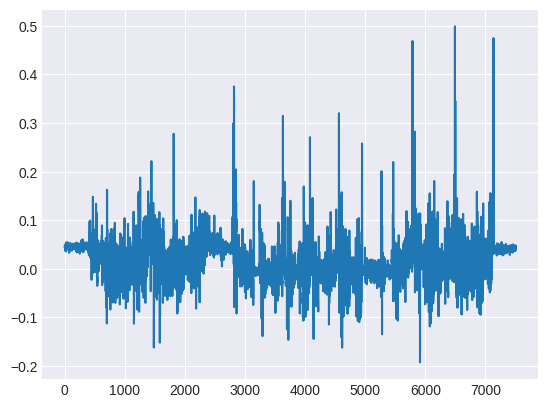

In [63]:
plt.plot((res))

In [190]:
user_data

{'b': array([ 0.01717721, -0.00090143, -0.22783722]),
 'L': array([[ 1.00071027e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.68939984e-04,  1.00249633e+00,  0.00000000e+00],
        [-4.15551978e-04,  5.24148325e-03,  9.79680800e-01]]),
 'aRws': array([[ 0.99992761, -0.00194757, -0.0118734 ],
        [ 0.00191487,  0.99999434, -0.00276533],
        [ 0.01187872,  0.00274239,  0.99992568]]),
 'w_offset': array([-1.41834239,  0.53356501,  1.39619212]),
 'w_rotation': array([[ 9.99871308e-01, -1.37727675e-03, -1.60339259e-02],
        [ 2.28738052e-04,  1.00018114e+00, -2.04775333e-02],
        [ 1.70235145e-02, -7.47902361e-03,  1.00021811e+00]])}

In [ ]:
q = np.einsum('ni,ij,nj->n', d, M, d)

In [19]:
import numpy as np
from numpy.linalg import cholesky, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_geometric_ellipsoid_with_projections(center, L, g, raw_data):
    """
    Plots:
    - Fitted 3D ellipsoid surface
    - Raw 3D IMU data
    - 2D projections (XY, XZ, YZ) showing both raw data and ellipsoid projection
    """

    # Generate ellipsoid surface points
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 60)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Scale, rotate, and translate sphere to form ellipsoid
    sphere = np.stack((x, y, z), axis=-1)
    sphere = sphere.reshape(-1,3)
    
    Y = g * sphere                     # points on radius-g sphere
    # Solve L X^T = Y^T  (triangular solve for each row)
    X = solve(L, Y.T).T           # X = L^{-1} Y without forming L^{-1}
    ellipsoid = center + X
    ellipsoid = ellipsoid.reshape((60,60,3))

    X, Y, Z = ellipsoid[:, :, 0], ellipsoid[:, :, 1], ellipsoid[:, :, 2]

    # Flatten ellipsoid surface points for projection plotting
    ellipsoid_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

    # Extract raw data
    ax_vals = raw_data[:, 0]
    ay_vals = raw_data[:, 1]
    az_vals = raw_data[:, 2]

    # Setup figure and subplots manually
    fig = plt.figure(figsize=(12, 10))

    # 3D plot in position 1
    ax3d = fig.add_subplot(2, 2, 1, projection='3d')
    ax3d.plot_surface(X, Y, Z, rstride=2, cstride=2, color='cyan', alpha=0.3, linewidth=0)
    ax3d.scatter(ax_vals, ay_vals, az_vals, c='black', s=5, alpha=0.6)
    ax3d.set_title('3D Ellipsoid Fit')
    ax3d.set_xlabel('ax')
    ax3d.set_ylabel('ay')
    ax3d.set_zlabel('az')

    max_radius = 1
    for axis in [ax3d.set_xlim, ax3d.set_ylim, ax3d.set_zlim]:
        axis(center[0] - max_radius, center[0] + max_radius)

    # Create other 2D subplots manually
    axs = [ax3d]
    for i in range(2, 5):  # subplot positions 2, 3, 4
        axs.append(fig.add_subplot(2, 2, i))

    # Define projections: (index_x, index_y, title, color)
    projections = [
        (0, 1, 'XY', 'green'),
        (0, 2, 'XZ', 'purple'),
        (1, 2, 'YZ', 'orange'),
    ]

    # Common axis limits for projections
    val = np.max(np.abs(raw_data)) + 0.2
    axis_lim = [-val, val]
    #val = 1.5
    #axis_lim = [-val, val]

    for k, (i, j, title, color) in enumerate(projections):
        ax = axs[k + 1]
        ax.scatter(raw_data[:, i], raw_data[:, j], c='black', s=10, alpha=0.6, label='Raw')
        ax.scatter(ellipsoid_points[:, i], ellipsoid_points[:, j], c=color, s=1, alpha=0.5, label='Ellipsoid')
        ax.set_xlabel(['ax', 'ay', 'az'][i])
        ax.set_ylabel(['ax', 'ay', 'az'][j])
        ax.set_title(f'{title} Projection')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlim(axis_lim)
        ax.set_ylim(axis_lim)
        ax.legend(loc='lower right', fontsize='small')

    plt.tight_layout()
    plt.show()

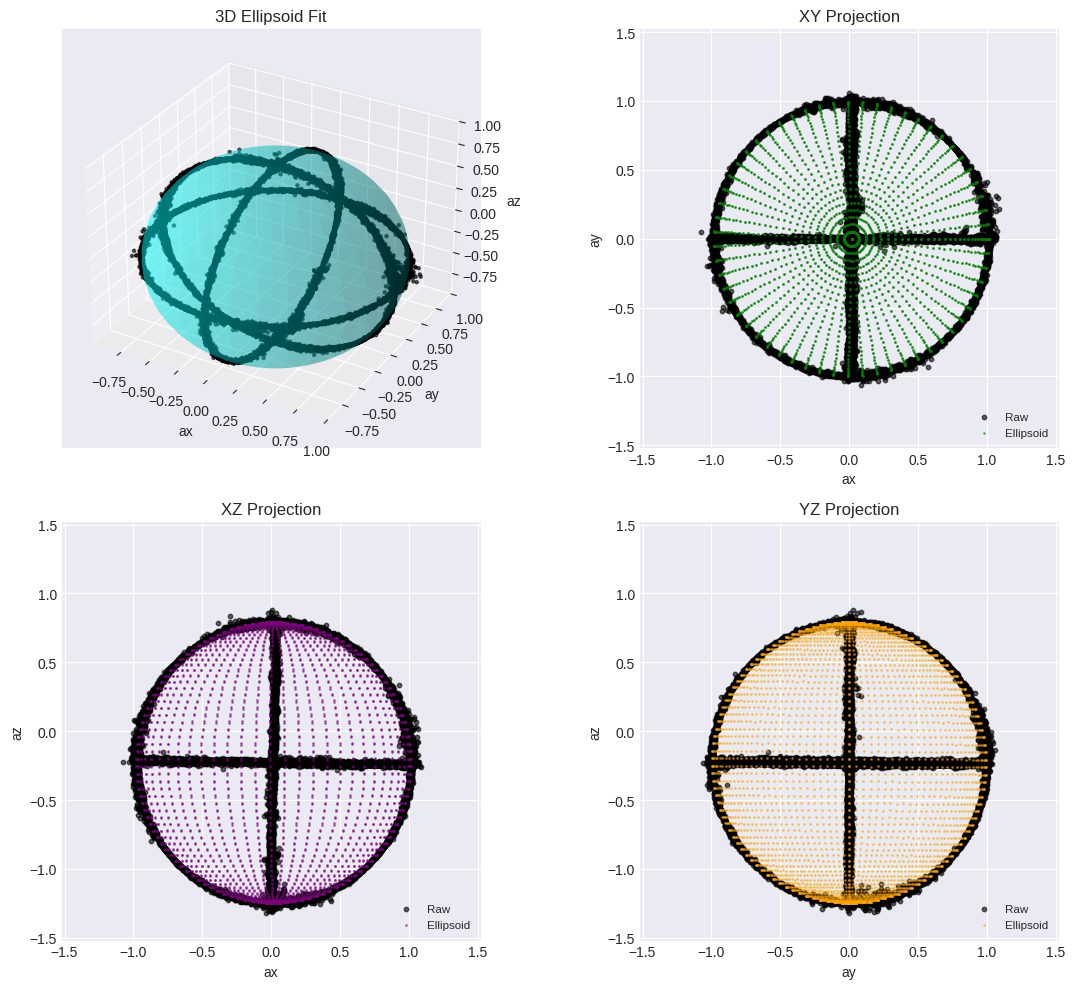

In [20]:
# Call the function
plot_geometric_ellipsoid_with_projections(out['b'], out['L'], 1, A)

# Calibrate Accelerometer Sensor Frame Rotation

In [ ]:
with open("user_data.pkl", "rb") as f:
    user_data = pickle.load(f)

In [21]:
def geometric_calibration(raw_data: dict, ctx: dict) -> dict:

    a = raw_data['a']
    a_cal = ctx['L'] @ (a - ctx['b'])

    raw_data['a'] = a_cal    

    return raw_data

In [22]:
user_data = {}
user_data['b'] = out['b']
user_data['L'] = out['L']

In [23]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            callback=geometric_calibration,
            user_data=user_data
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 312
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [24]:
samples = imu.capture(duration_s=300.0, max_samples=1e6, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.00,+1.00,+0.00) g  G=(  -1.4,  +0.5,  +1.5) °/s  T=23.91°C  n_samples=8610     
🛑 Stopped by user.

📦 Recorded 8610 samples.


In [25]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


In [26]:
samples[0]

{'t': 1763122063.306782,
 'a': array([0.01261691, 0.0032322 , 0.99672713]),
 'w': [-1.3893129770992367, 0.6030534351145038, 1.3358778625954197],
 'temp': 22.98}

In [27]:
data_a = np.array([d['a'] for d in samples])
data_w = np.array([d['w'] for d in samples])

In [28]:
data_a[:5]

array([[ 1.26169061e-02,  3.23220091e-03,  9.96727133e-01],
       [ 1.34720052e-02,  2.00868032e-03,  9.98394638e-01],
       [ 1.28612201e-02,  1.88614113e-03,  1.00497170e+00],
       [ 1.23725921e-02, -1.29574122e-03,  1.00184593e+00],
       [ 1.35941622e-02, -8.05912769e-04,  1.00017372e+00]])

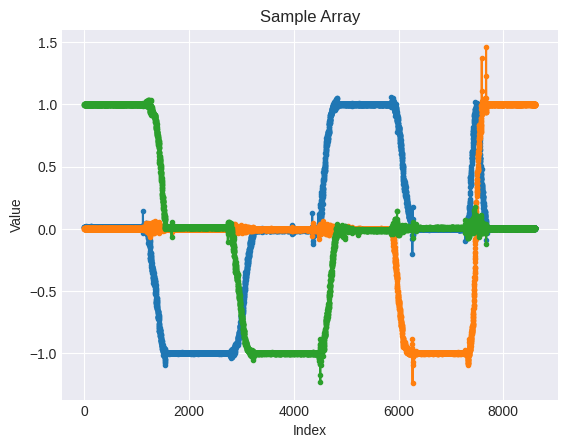

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(arr):
    """
    arr: numpy array of shape (1, n) or (n,)
    Produces a simple line plot of the values.
    """
    arr = np.squeeze(arr)  # flatten (1, n) to (n,)
    
    fig, ax = plt.subplots()
    ax.plot(arr, marker=".")
    ax.set_title("Sample Array")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.grid(True)
    
    plt.show()

plot_sample(data_a)

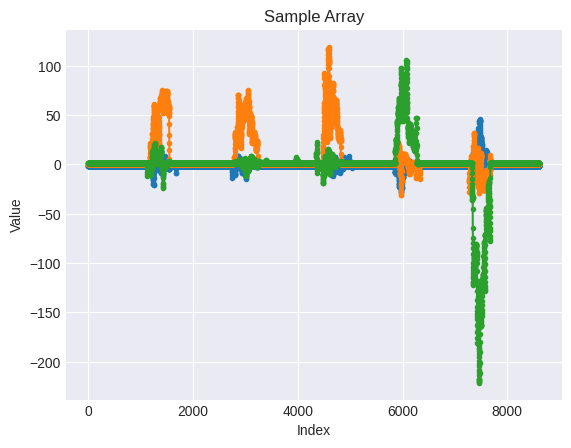

In [30]:
plot_sample(data_w)

In [31]:
vals = [np.linalg.norm(val) for val in data_w]

In [32]:
np.max(vals)

np.float64(224.36198413333494)

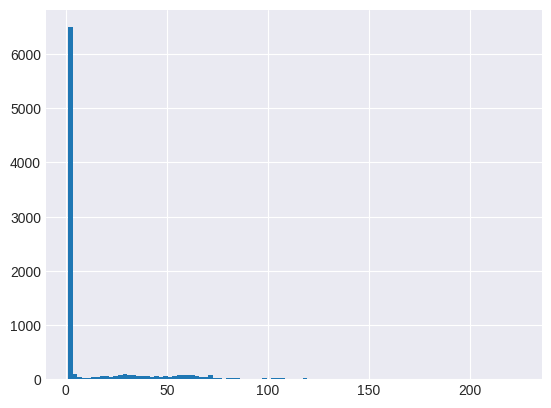

In [33]:
counts, bin_edges, patches = plt.hist(vals, bins=100)

In [34]:
bin_edges

array([  1.22903134,   3.72470611,   6.22038087,   8.71605564,
        11.21173041,  13.70740517,  16.20307994,  18.6987547 ,
        21.19442947,  23.69010424,  26.185779  ,  28.68145377,
        31.17712854,  33.6728033 ,  36.16847807,  38.66415283,
        41.1598276 ,  43.65550237,  46.15117713,  48.6468519 ,
        51.14252667,  53.63820143,  56.1338762 ,  58.62955096,
        61.12522573,  63.6209005 ,  66.11657526,  68.61225003,
        71.1079248 ,  73.60359956,  76.09927433,  78.5949491 ,
        81.09062386,  83.58629863,  86.08197339,  88.57764816,
        91.07332293,  93.56899769,  96.06467246,  98.56034723,
       101.05602199, 103.55169676, 106.04737152, 108.54304629,
       111.03872106, 113.53439582, 116.03007059, 118.52574536,
       121.02142012, 123.51709489, 126.01276965, 128.50844442,
       131.00411919, 133.49979395, 135.99546872, 138.49114349,
       140.98681825, 143.48249302, 145.97816779, 148.47384255,
       150.96951732, 153.46519208, 155.96086685, 158.45

### Filter Acceleration Values by Norm of Gyroscope Readings

In [34]:
limit_w = 3.7

In [35]:
data_a.shape

(8610, 3)

In [36]:
data_w.shape

(8610, 3)

In [37]:
# Filter by Gyro reading
data_a_filtered = []
data_w_filtered = []
for a, w in zip(data_a, data_w):
    if np.linalg.norm(w) < limit_w:
        data_a_filtered.append(a)
        data_w_filtered.append(w)
    


In [38]:
data_a_filtered[:10]

[array([0.01261691, 0.0032322 , 0.99672713]),
 array([0.01347201, 0.00200868, 0.99839464]),
 array([0.01286122, 0.00188614, 1.0049717 ]),
 array([ 0.01237259, -0.00129574,  1.00184593]),
 array([ 1.35941622e-02, -8.05912769e-04,  1.00017372e+00]),
 array([1.16396500e-02, 5.01872367e-05, 9.98863522e-01]),
 array([ 1.10288649e-02, -4.39477071e-04,  9.98622036e-01]),
 array([ 0.01078455, -0.00203042,  0.99311268]),
 array([9.68513773e-03, 5.39162123e-04, 9.98388533e-01]),
 array([1.10288649e-02, 4.17148208e-04, 9.98865695e-01])]

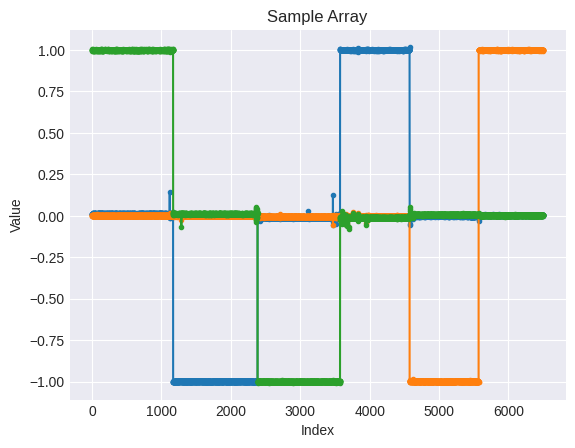

In [39]:
plot_sample(data_a_filtered)

In [40]:
orientations = np.array([[ 1,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  1],
       [ 0,  0, -1]])

In [41]:
for val in orientations:
    print(np.dot(data_a_filtered[0], val))

0.012616906086464805
-0.012616906086464805
0.003232200909554378
-0.003232200909554378
0.9967271325461742
-0.9967271325461742


In [42]:
orientations.shape

(6, 3)

In [43]:
# Sort Acceleration Vectors by Direction
data_samples = [[] for _ in range(6)]
for a in data_a_filtered:
    for idx, val in enumerate(orientations):
        if np.dot(a,val) > 0.9:
            data_samples[idx].append(a)
            continue

In [44]:
data_samples[0][:2]

[array([ 1.00343245e+00, -5.03944592e-05, -2.23699867e-02]),
 array([ 1.00294383, -0.00629165, -0.02335913])]

In [45]:
plot_data = []
for idx in range(6):
    for val in data_samples[idx]:
        plot_data.append(val)

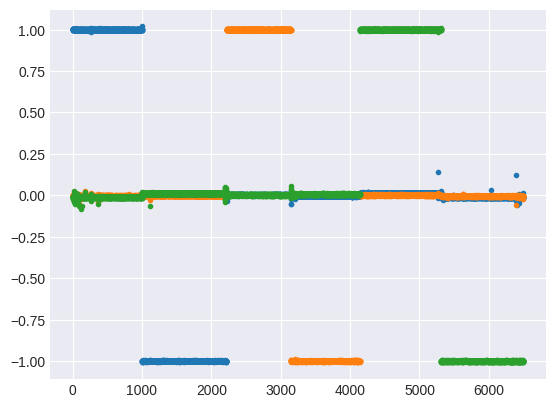

In [46]:
plt.plot(plot_data, '.')

In [47]:
# Calculate Mean
for idx in range(len(data_samples)):
    data_samples[idx] = np.mean(np.array(data_samples[idx]), axis=0)

In [48]:
data_samples

[array([ 0.99984333, -0.0031006 , -0.01184811]),
 array([-9.99581842e-01, -5.33699341e-04,  1.14443239e-02]),
 array([0.00301192, 0.99973221, 0.00230441]),
 array([-0.00215304, -0.9997448 ,  0.00703343]),
 array([0.01232281, 0.00150787, 0.99941772]),
 array([-0.01188806, -0.00479371, -1.00034922])]

In [49]:
import numpy as np

def estimate_rotation_from_six_poses(accel_rows):
    """
    accel_rows: iterable of 6 vectors, each a length-3 numpy array,
                measured gravity vectors in the SENSOR frame, one per major pose.
                Units can be g or m/s^2. Magnitude can vary slightly.
    Returns:
        R_ws: 3x3 rotation matrix that maps sensor-frame vectors -> world-frame vectors
              so that world_vec ≈ R_ws @ sensor_vec
    """
    A = np.vstack([np.asarray(v, dtype=float) for v in accel_rows])
    # 1) normalize
    A = A / np.linalg.norm(A, axis=1, keepdims=True)

    # 2) build corresponding world directions for each row by dominant axis + sign
    #    Gravity direction in world for these poses is one of the six cardinal axes.
    B = np.zeros_like(A)
    for i, v in enumerate(A):
        ax = np.argmax(np.abs(v))
        sgn = np.sign(v[ax]) if v[ax] != 0 else 1.0
        e = np.zeros(3)
        e[ax] = sgn
        B[i] = e

    # 3) Kabsch: find R minimizing sum ||R*a_i - b_i||^2
    # Build correlation H = B^T A
    H = B.T @ A
    U, S, Vt = np.linalg.svd(H)
    R = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt
    return R

def rotation_matrix_to_euler_zyx(R):
    """
    Convert rotation matrix to ZYX Euler angles (yaw, pitch, roll) in radians.
    Returns yaw, pitch, roll with the convention:
      R = Rz(yaw) * Ry(pitch) * Rx(roll)
    """
    # guard for numerical drift
    r20 = R[2, 0]
    r20 = np.clip(r20, -1.0, 1.0)
    pitch = -np.arcsin(r20)
    yaw = np.arctan2(R[1,0], R[0,0])
    roll = np.arctan2(R[2,1], R[2,2])
    return yaw, pitch, roll

aR_ws = estimate_rotation_from_six_poses(data_samples)
yaw, pitch, roll = rotation_matrix_to_euler_zyx(aR_ws)

print("Rotation Acceleration Sensor Frame -> World Frame")
print("aR_ws (sensor -> world):\n", aR_ws)
print("Yaw, Pitch, Roll (rad):", yaw, pitch, roll)
print("Yaw, Pitch, Roll (deg):", np.degrees([yaw, pitch, roll]))


Rotation Acceleration Sensor Frame -> World Frame
aR_ws (sensor -> world):
 [[ 0.99992761 -0.00194757 -0.0118734 ]
 [ 0.00191487  0.99999434 -0.00276533]
 [ 0.01187872  0.00274239  0.99992568]]
Yaw, Pitch, Roll (rad): 0.001915004048599463 -0.011879002600418555 0.0027425872023040592
Yaw, Pitch, Roll (deg): [ 0.10972165 -0.68061671  0.15713867]


### Store the Rotation Matrix

In [50]:
import pickle

accel_rotation_data = {"rotation": aR_ws}

with open("accel_rotation_data.pkl", "wb") as f:
    pickle.dump(accel_rotation_data, f)

In [51]:
with open("rotation_data.pkl", "rb") as f:
    rotation_data = pickle.load(f)

In [52]:
def geometric_calibration(raw_data: dict, ctx: dict) -> dict:

    a = raw_data['a']
    a_cal = ctx['L'] @ (a - ctx['b'])

    if 'aRws' in ctx and ctx['aRws'] is not None:
        a_cal = ctx['aRws'] @ a_cal

    raw_data['a'] = a_cal    

    return raw_data

In [53]:
user_data['aRws'] = aR_ws

In [54]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            callback=geometric_calibration,
            user_data=user_data
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 624
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [55]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.00,+0.00,+1.00) g  G=(  -1.4,  +0.5,  +1.4) °/s  T=23.98°C  n_samples=3912     
🛑 Stopped by user.

📦 Recorded 3912 samples.


In [56]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


📊 Recorded 3912 samples over 19.481 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.8 Hz → Δt = 4.98 ms


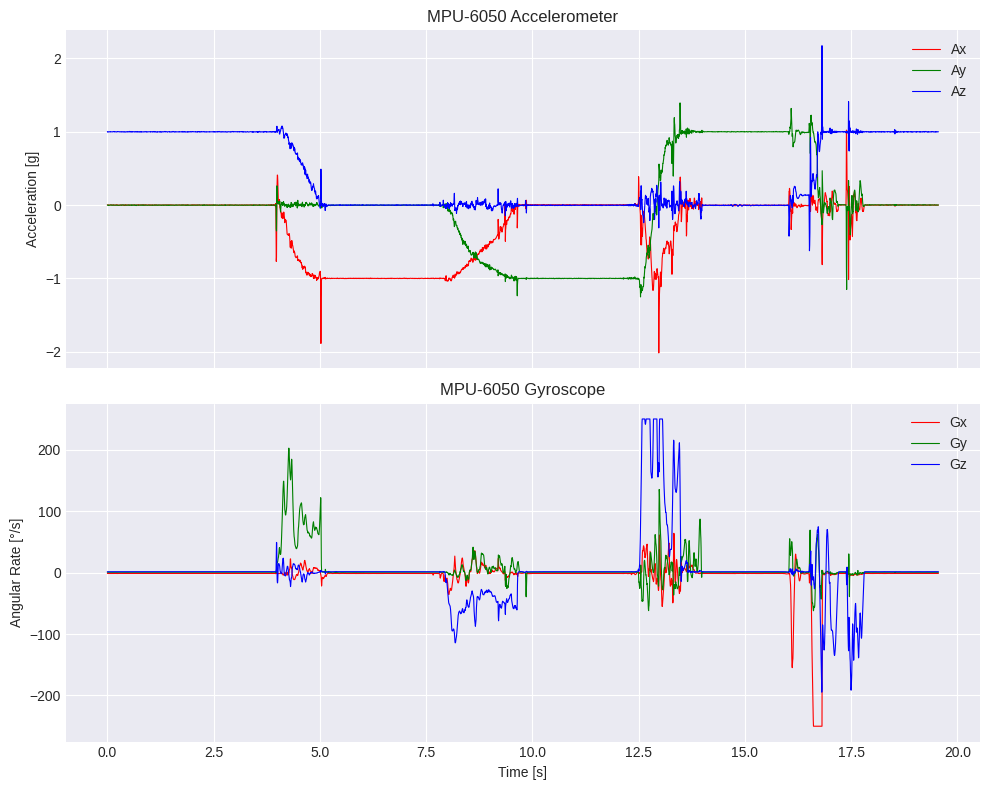

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpu6050_dictlog(data_log, sample_rate_hz=200):
    """
    Plot MPU-6050 data when each sample is a dict:
    {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}
    
    Arguments
    ----------
    data_log : list of dicts
        Recorded data points.
    sample_rate_hz : float
        Expected sample rate from the sensor configuration (Hz).
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to plot.")
        return

    n = len(data_log)

    # Extract recorded timestamps (real host-side times)
    host_t = np.array([d["t"] for d in data_log])
    total_time = host_t[-1] - host_t[0]
    actual_rate = (n - 1) / total_time if total_time > 0 else 0.0
    expected_rate = sample_rate_hz

    print(f"📊 Recorded {n} samples over {total_time:.3f} s")
    print(f"⚙️ Expected sample rate: {expected_rate:.1f} Hz → Δt = {1/expected_rate*1000:.2f} ms")
    print(f"🧠 Inferred actual rate: {actual_rate:.1f} Hz → Δt = {1/actual_rate*1000:.2f} ms")

    # Warn if difference >10%
    if abs(actual_rate - expected_rate) / expected_rate > 0.1:
        print("⚠️ WARNING: inferred rate differs from expected by >10% (host read delay or mis-set SMPLRT_DIV)")

    # Use synthetic uniform time base (true sample spacing)
    dt = 1.0 / expected_rate
    t = np.arange(n) * dt

    # Extract arrays
    ax = np.array([d["a"][0] for d in data_log])
    ay = np.array([d["a"][1] for d in data_log])
    az = np.array([d["a"][2] for d in data_log])
    gx = np.array([d["w"][0] for d in data_log])
    gy = np.array([d["w"][1] for d in data_log])
    gz = np.array([d["w"][2] for d in data_log])

    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Accelerometer ---
    axs[0].plot(t, ax, "r-", lw=0.8, label="Ax")
    axs[0].plot(t, ay, "g-", lw=0.8, label="Ay")
    axs[0].plot(t, az, "b-", lw=0.8, label="Az")
    axs[0].set_ylabel("Acceleration [g]")
    axs[0].set_title("MPU-6050 Accelerometer")
    axs[0].legend(loc="upper right")

    # --- Gyroscope ---
    axs[1].plot(t, gx, "r-", lw=0.8, label="Gx")
    axs[1].plot(t, gy, "g-", lw=0.8, label="Gy")
    axs[1].plot(t, gz, "b-", lw=0.8, label="Gz")
    axs[1].set_ylabel("Angular Rate [°/s]")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_title("MPU-6050 Gyroscope")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_mpu6050_dictlog(samples)

In [58]:
samples[0]

{'t': 1763122209.0744915,
 'a': array([1.47773485e-03, 7.39468092e-04, 9.99333353e-01]),
 'w': [-1.3969465648854962, 0.5877862595419847, 1.3740458015267176],
 'temp': 23.927058823529414}

# Calibrate Gyroscope Offset

In [171]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 624
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [172]:
samples = imu.capture(duration_s=300.0, max_samples=1e6, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.031,+0.005,+0.789) g  G=(-1.39,+0.50,+1.34) °/s  T=24.74°C  n_samples=2878         
🛑 Stopped by user.

📦 Recorded 2878 samples.


In [173]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


In [92]:
samples[0]

{'t': 1763125866.991249,
 'a': [0.02685546875, 0.001953125, 0.78662109375],
 'w': [-1.4122137404580153, 0.6183206106870229, 1.4351145038167938],
 'temp': 24.421176470588236}

In [93]:
w_samples = [c['w'] for c in samples]

In [94]:
w_samples[:2]

[[-1.4122137404580153, 0.6183206106870229, 1.4351145038167938],
 [-1.381679389312977, 0.4961832061068702, 1.3358778625954197]]

In [95]:
w_offset = np.mean(np.array([sample['w'] for sample in samples]), axis=0)
w_offset

array([-1.97986781, -1.6454996 ,  3.14018916])

In [96]:
gyro_offset = {"offset": w_offset}

#with open("gyro_offset.pkl", "wb") as f:
#    pickle.dump(gyro_offset, f)

📊 Recorded 2878 samples over 14.332 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.7 Hz → Δt = 4.98 ms


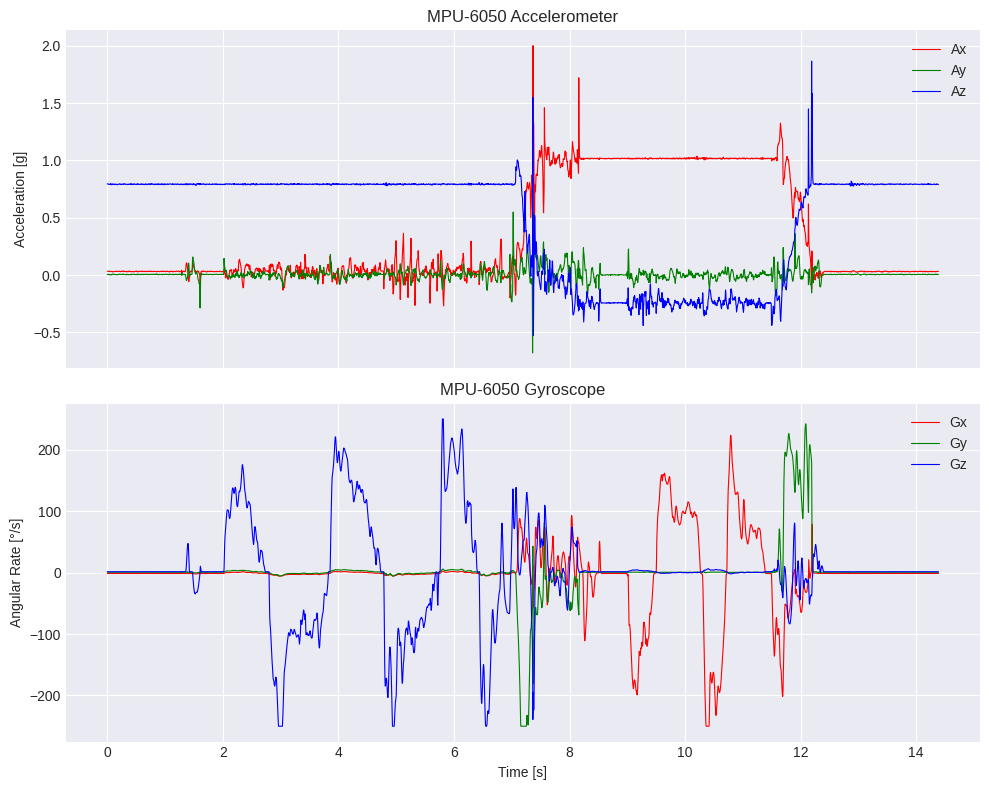

In [174]:
plot_mpu6050_dictlog(samples)

# Calibrate Gyroscope Sensor Affine Transformation

## Need Gyro Offset!

In [18]:
import pickle
with open("user_data.pkl", "rb") as f:
    user_data = pickle.load(f)

In [31]:
user_data

{'b': array([ 0.01717721, -0.00090143, -0.22783722]),
 'L': array([[ 1.00071027e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.68939984e-04,  1.00249633e+00,  0.00000000e+00],
        [-4.15551978e-04,  5.24148325e-03,  9.79680800e-01]]),
 'aRws': array([[ 0.99992761, -0.00194757, -0.0118734 ],
        [ 0.00191487,  0.99999434, -0.00276533],
        [ 0.01187872,  0.00274239,  0.99992568]]),
 'w_offset': array([-1.41834239,  0.53356501,  1.39619212])}

In [32]:
def geometric_calibration(raw_data: dict, ctx: dict) -> dict:

    a = raw_data['a']
    a_cal = ctx['L'] @ (a - ctx['b'])

    if 'aRws' in ctx and ctx['aRws'] is not None:
        a_cal = ctx['aRws'] @ a_cal

    if 'w_offset' in ctx and ctx['w_offset'] is not None:
       raw_data['w'] -= ctx['w_offset']

    raw_data['a'] = a_cal    

    return raw_data

In [28]:
user_data['w_offset'] = w_offset

In [37]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            callback=geometric_calibration,
            user_data=user_data
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 312
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [38]:
samples = imu.capture(duration_s=300.0, max_samples=1e6, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(-0.00,+1.00,-0.00) g  G=(  +0.1,  +0.1,  -0.1) °/s  T=25.16°C  n_samples=10843     
🛑 Stopped by user.

📦 Recorded 10843 samples.


In [39]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


📊 Recorded 10843 samples over 54.132 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.3 Hz → Δt = 4.99 ms


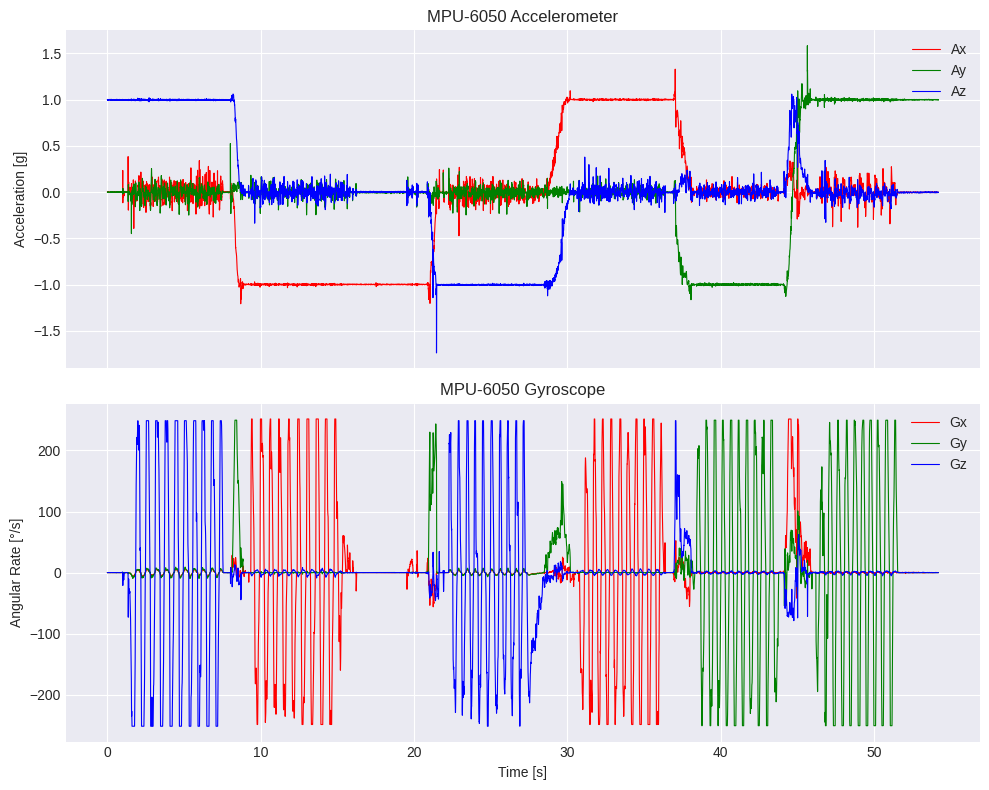

In [40]:
plot_mpu6050_dictlog(samples)

In [41]:
w_min = 200 #150
w_max = 240

In [42]:
orientations = [[ 1,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  1],
       [ 0,  0, -1]]

In [43]:
max_mag_subordinate = 10

# Filter by Turn Rate Magnitude
data_samples = [[] for _ in range(6)]
w_data = [sample['w'] for sample in samples]
for w in w_data:
    wx = w[0]
    wy = w[1]
    wz = w[2]
    for idx, val in enumerate(orientations):
        if np.dot(w/np.linalg.norm(w), val) > 0.9:
            # Check max and min values of dominant direction
            if np.abs(np.max(w)) > np.abs(np.min(w)):
                if np.max(w) < w_min or np.max(w) > w_max:
                    continue
            else:
                if np.min(w) > -w_min or np.min(w) < -w_max:
                    continue

            # Check magnitude of subordinate directions
            if idx == 0 or idx == 1:
                if np.linalg.norm([wy,wz]) > max_mag_subordinate:
                    continue
            if idx == 2 or idx == 3:
                if np.linalg.norm([wx,wz]) > max_mag_subordinate:
                    continue
            if idx == 4 or idx == 5:
                if np.linalg.norm([wx,wy]) > max_mag_subordinate:
                    continue
            
            
            data_samples[idx].append(w)
            continue


In [44]:
for v in data_samples[1]:
    data_samples[0].append(-v)
    
for v in data_samples[3]:
    data_samples[2].append(-v)

for v in data_samples[5]:
    data_samples[4].append(-v)

In [45]:
len(data_samples[0])

358

In [46]:
len(data_samples[1])

211

In [47]:
for i in range(6):
    print(len(data_samples[i]))

358
211
284
123
326
154


In [48]:
data_samples[0][:5]

[array([ 2.03433610e+02,  1.99259413e-01, -3.66336769e+00]),
 array([ 2.26540480e+02, -6.02825715e-02, -3.84657380e+00]),
 array([ 2.36364907e+02, -2.05320739e-01, -3.95344403e+00]),
 array([ 2.18593915e+02, -1.21351274e-01, -3.60993257e+00]),
 array([ 2.33219869e+02, -6.02825715e-02, -4.22825319e+00])]

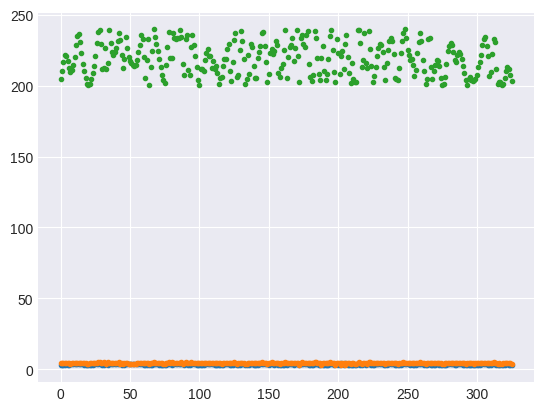

In [49]:
plt.plot(data_samples[4], '.')

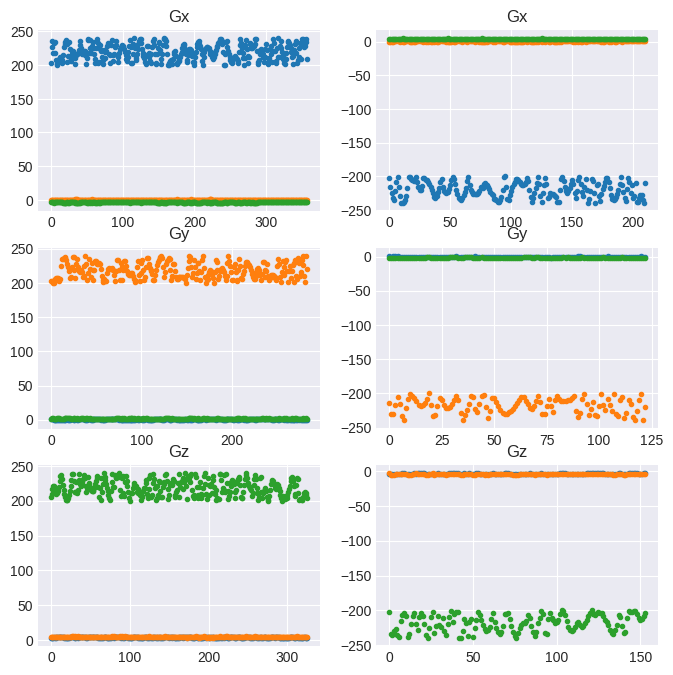

In [50]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 2, figsize=(8,8))

labels = ['Gx', 'Gy', 'Gz']

for j in range(2):
    for i in range(3):
        idx = i*2 + j
        axes[i, j].set_title(labels[i])
        axes[i, j].plot(data_samples[i*2+j], '.', label=labels[i])
        #axes[i, j].legend()

#plt.tight_layout()
plt.show()

In [51]:
data_samples[0][:10][0]

array([ 2.03433610e+02,  1.99259413e-01, -3.66336769e+00])

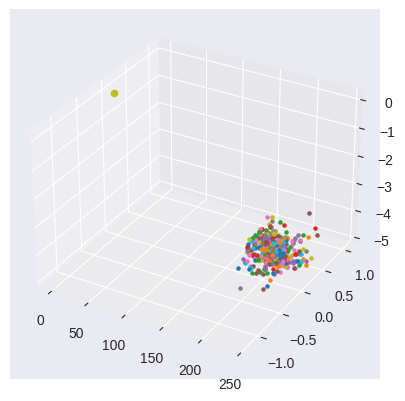

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for v in data_samples[0]:
    ax.scatter(v[0], v[1], v[2], marker='.')
    
ax.scatter(0, 0, 0, marker='o')

plt.show()

In [148]:
a = np.mean(data_samples[2], axis=0)

In [149]:
b = np.mean(data_samples[5], axis=0)

In [150]:
np.dot(a/np.linalg.norm(a),b/np.linalg.norm(b))

np.float64(-0.027908217750287796)

In [53]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# fig = plt.figure(figsize=(8,8))

# labels = ['Gx', 'Gy', 'Gz']

# for j in range(2):
#     for i in range(3):
#         idx = i*2 + j
#         ax = fig.add_subplot(3, 2, idx+1, projection='3d')
#         for v in data_samples[idx]:
#             ax.scatter(v[0], v[1], v[2], marker='.')
#         ax.scatter(0, 0, 0, marker='o')

# plt.tight_layout()
# plt.show()

In [54]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# fig = plt.figure(figsize=(8,8))

# labels = ['Gx', 'Gy', 'Gz']

# for j in range(2):
#     for i in range(3):
#         idx = i*2 + j
#         ax = fig.add_subplot(3, 2, idx+1, projection='3d')
#         for v in data_samples[idx]:
#             v = v/np.linalg.norm(v)
#             ax.scatter(v[0], v[1], v[2], marker='.')
#         ax.scatter(0, 0, 0, marker='o')

# plt.tight_layout()
# plt.show()

In [55]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# for v in data_samples[0]:
#     v = v/np.linalg.norm(v)
#     ax.scatter(v[0], v[1], v[2], marker='.')

# ax.scatter(0, 0, 0, marker='o')

# plt.show()

In [56]:
plot_data = []
for idx in range(6):
    for val in data_samples[idx]:
        plot_data.append(val)

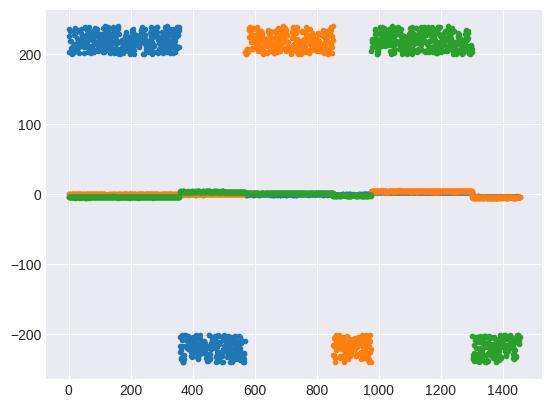

In [57]:
plt.plot(plot_data, '.')

#### Transformation

$\mathbf{U} = [u_x,u_y,u_z] $ 

$\mathbf{U}$ transforms vectors from the global system to the local system - this is an **active** transformation, **not** a coordiante transformation. 

$\mathbf{\omega} = \mathbf{U} \: \omega_{true}$

$\mathbf{\omega}_{true} = \mathbf{U}^{-1} \: \omega$

In [58]:
ux = np.mean(data_samples[0], axis=0)
uy = np.mean(data_samples[2], axis=0)
uz = np.mean(data_samples[4], axis=0)

ux = ux / np.linalg.norm(ux)
uy = uy / np.linalg.norm(uy)
uz = uz / np.linalg.norm(uz)

In [59]:
print(ux)
print(uy)
print(uz)

[ 9.99854955e-01 -5.77161718e-04 -1.70216493e-02]
[0.00149691 0.99997112 0.0074517 ]
[0.01605875 0.02046322 0.99966163]


In [60]:
U = np.array([ux, uy, uz]).T

In [61]:
U

array([[ 9.99854955e-01,  1.49690961e-03,  1.60587506e-02],
       [-5.77161718e-04,  9.99971115e-01,  2.04632244e-02],
       [-1.70216493e-02,  7.45169961e-03,  9.99661629e-01]])

In [62]:
T = np.linalg.inv(U)

In [63]:
T

array([[ 9.99871308e-01, -1.37727675e-03, -1.60339259e-02],
       [ 2.28738052e-04,  1.00018114e+00, -2.04775333e-02],
       [ 1.70235145e-02, -7.47902361e-03,  1.00021811e+00]])

In [64]:
np.linalg.det(U)

np.float64(0.9996089102755367)

In [118]:
T

array([[ 9.99871308e-01, -1.37727675e-03, -1.60339259e-02],
       [ 2.28738052e-04,  1.00018114e+00, -2.04775333e-02],
       [ 1.70235145e-02, -7.47902361e-03,  1.00021811e+00]])

In [119]:
np.linalg.det(T)

np.float64(1.0003912427354773)

In [151]:
U

array([[ 9.99854955e-01,  1.49690961e-03,  1.60587506e-02],
       [-5.77161718e-04,  9.99971115e-01,  2.04632244e-02],
       [-1.70216493e-02,  7.45169961e-03,  9.99661629e-01]])

# Capturing Data with Calibration

In [66]:
import numpy as np

In [153]:
def geometric_calibration(raw_data: dict, ctx: dict) -> dict:

    a = raw_data['a']
    a_cal = ctx['L'] @ (a - ctx['b'])

    if 'aRws' in ctx and ctx['aRws'] is not None:
        a_cal = ctx['aRws'] @ a_cal

    if 'w_offset' in ctx and ctx['w_offset'] is not None:
       raw_data['w'] -= ctx['w_offset']

    if 'w_rotation' in ctx and ctx['w_rotation'] is not None:
       raw_data['w'] =  ctx['w_rotation'] @ raw_data['w']

    raw_data['a'] = a_cal    

    return raw_data

In [158]:
user_data['w_rotation'] = T

In [66]:
user_data

{'b': array([ 0.01717721, -0.00090143, -0.22783722]),
 'L': array([[ 1.00071027e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.68939984e-04,  1.00249633e+00,  0.00000000e+00],
        [-4.15551978e-04,  5.24148325e-03,  9.79680800e-01]]),
 'aRws': array([[ 0.99992761, -0.00194757, -0.0118734 ],
        [ 0.00191487,  0.99999434, -0.00276533],
        [ 0.01187872,  0.00274239,  0.99992568]]),
 'w_offset': array([-1.41834239,  0.53356501,  1.39619212]),
 'w_rotation': array([[ 9.99871308e-01, -1.37727675e-03, -1.60339259e-02],
        [ 2.28738052e-04,  1.00018114e+00, -2.04775333e-02],
        [ 1.70235145e-02, -7.47902361e-03,  1.00021811e+00]])}

In [179]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,\
            callback=geometric_calibration,
            user_data=user_data
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [180]:
samples = imu.capture(duration_s=300.0, max_samples=1e6, print_rate_hz=20.0)      

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.007,+0.002,+0.999) g  G=(+0.04,-0.04,+0.02) °/s  T=24.77°C  n_samples=5201        
🛑 Stopped by user.

📦 Recorded 5201 samples.


In [181]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


📊 Recorded 5201 samples over 25.931 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.5 Hz → Δt = 4.99 ms


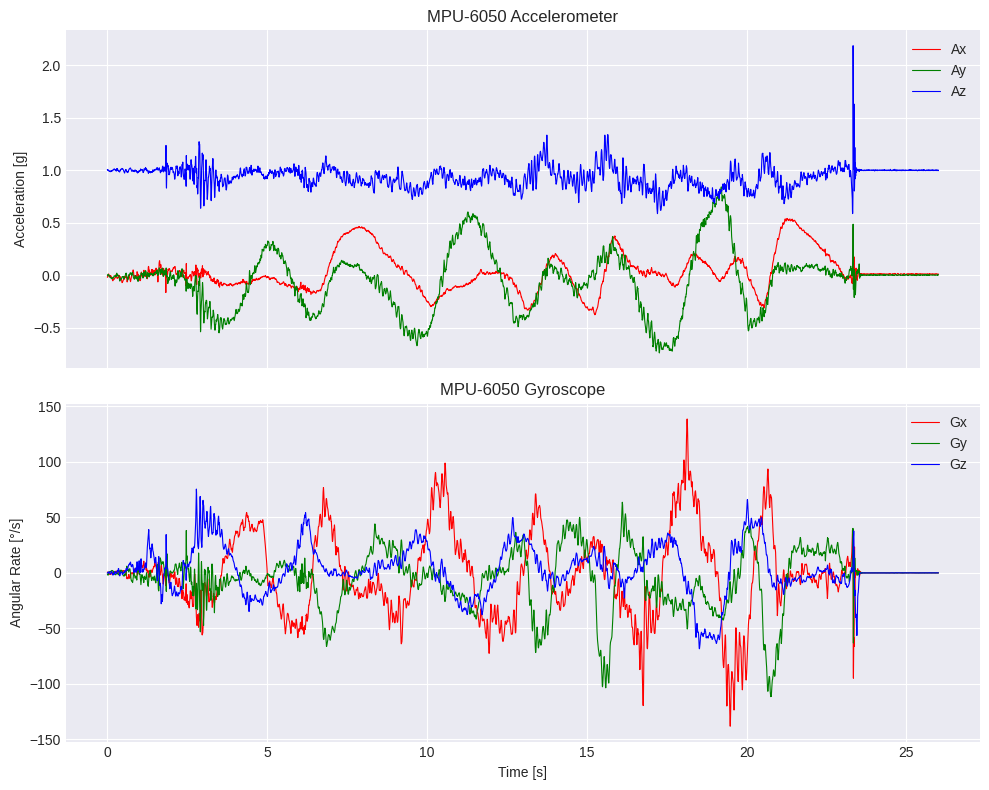

In [182]:
plot_mpu6050_dictlog(samples)

In [73]:
user_data

{'b': array([ 0.01717721, -0.00090143, -0.22783722]),
 'L': array([[ 1.00071027e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.68939984e-04,  1.00249633e+00,  0.00000000e+00],
        [-4.15551978e-04,  5.24148325e-03,  9.79680800e-01]]),
 'aRws': array([[ 0.99992761, -0.00194757, -0.0118734 ],
        [ 0.00191487,  0.99999434, -0.00276533],
        [ 0.01187872,  0.00274239,  0.99992568]]),
 'w_offset': array([-1.41834239,  0.53356501,  1.39619212]),
 'w_rotation': array([[ 9.99871308e-01, -1.37727675e-03, -1.60339259e-02],
        [ 2.28738052e-04,  1.00018114e+00, -2.04775333e-02],
        [ 1.70235145e-02, -7.47902361e-03,  1.00021811e+00]])}

In [178]:
samples[0]

{'t': 1762880733.7018661,
 'a': array([-0.0072737 , -0.00650736,  0.99858128]),
 'w': array([ 0.03085459,  0.02747429, -0.09858384]),
 'temp': 24.527058823529412}

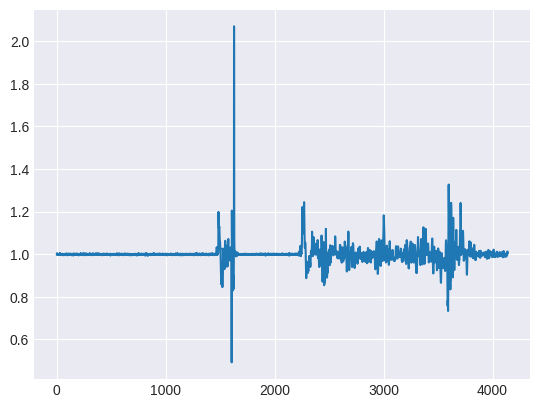

In [102]:
data = [np.linalg.norm(s['a']) for s in samples]
plt.plot(data)

In [77]:
np.min(data)

np.float64(0.33612915413247385)

In [71]:
user_data

{'b': array([ 0.01717721, -0.00090143, -0.22783722]),
 'L': array([[ 1.00071027e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.68939984e-04,  1.00249633e+00,  0.00000000e+00],
        [-4.15551978e-04,  5.24148325e-03,  9.79680800e-01]]),
 'aRws': array([[ 0.99992761, -0.00194757, -0.0118734 ],
        [ 0.00191487,  0.99999434, -0.00276533],
        [ 0.01187872,  0.00274239,  0.99992568]])}

In [67]:
import pickle

with open("user_data.pkl", "wb") as f:
    pickle.dump(user_data, f)

In [79]:
with open("user_data.pkl", "rb") as f:
    user_data = pickle.load(f)

In [80]:
user_data

{'b': array([ 0.01717721, -0.00090143, -0.22783722]),
 'L': array([[ 1.00071027e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.68939984e-04,  1.00249633e+00,  0.00000000e+00],
        [-4.15551978e-04,  5.24148325e-03,  9.79680800e-01]]),
 'aRws': array([[ 0.99992761, -0.00194757, -0.0118734 ],
        [ 0.00191487,  0.99999434, -0.00276533],
        [ 0.01187872,  0.00274239,  0.99992568]]),
 'w_offset': array([-1.41834239,  0.53356501,  1.39619212]),
 'w_rotation': array([[ 9.99871308e-01, -1.37727675e-03, -1.60339259e-02],
        [ 2.28738052e-04,  1.00018114e+00, -2.04775333e-02],
        [ 1.70235145e-02, -7.47902361e-03,  1.00021811e+00]])}